##### Quantum Data Science 2023/2024
## Lecture 8 - Variational Quantum Classifier

*Machine Learning with quantum computers -  Section 5.1.3*

## Contents

0. [Execute circuit](#execute)
1. [VQC building blocks - Parameterized model](#ansatz)
2. [VQC building blocks - Measurement](#measurement)
      1) [Binary classification](#binary) 
      2) [Multi-class classification](#multi-class) 
3. [variational classifier for the ad_hoc dataset](#ad_hoc)

#### 0. Execute circuit

In [1]:
from qiskit import *
from qiskit.primitives import Sampler,Estimator
import numpy as np
import matplotlib.pyplot as plt

def execute_circuit(qc, shots=1024, seed=None, binary=False , primitive="sampler", observable=None, reverse=False):
    
    if reverse:
        qc = qc.reverse_bits()

    if primitive == "estimator":
        options = {"shots": shots, "seed": seed}
        estimator = Estimator(options=options)
    
        job = estimator.run(qc, observable)
        result = job.result()  
        
        return result
    
    elif primitive == "sampler":
        options = {"shots": shots, "seed": seed}
        sampler = Sampler(options=options)
    
        job = sampler.run(qc)
        result = job.result()  
        
        probability_dictionary = result.quasi_dists[0]

        if binary:
            
            probability_dictionary = probability_dictionary.binary_probabilities()

            #if reverse:
                #return {key[::-1]: value for key, value in probability_dictionary.items()}

            #else:
            
        return probability_dictionary
    

##### Recall our quantum machine learning building blocks and loop!

<p align="center">
  <img width="900" height="600" src="images/VQA_loop.png">
</p>

In [2]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

## 1. VQC building blocks - Parameterized model <a id="ansatz"></a>
We have seen different forms of encoding data. What about the variational form?

Recall that a single-qubit can be decomposed with three angles:

<p align="center">
  <img width="800" height="450" src="images/blochsphere.png">
</p>

Than can be decomposed into a parameterized gate in several forms: The most common is the $U$ gate:
$$
U(\theta,\phi,\beta) = R_z(\theta)R_y(\phi)R_z(\beta)
$$

For obtaining a general two-qubit gate, the arbitrary single-qubit gate , single Pauli rotations and CNOTS were shown to be sufficient, as shown in the following figure:

<p align="center">
  <img width="600" height="200" src="images/two_qubit_general.png">
</p>

Indeed, any $n$-qubit unitary can be decomposed into a sequence of single-qubit gates and CNOTs - universal gate set. It is a matter of decomposing the arbitrary gate $U(2^n)$ which is not trivial in itself. 

Still, we can consider the matrix exponential for the arbitrary unitary:

$$
U(\theta) = e^{A(\theta)}
$$

where $A(\theta)$ 

$$
A(\theta) = \sum_{i=1}^{d} i \theta_i P_i
$$
and $P_i$ is all the possible Pauli matrix combinations acting on $n$ qubits.

$$
P_i = \{I, \sigma_x , \sigma_y, \sigma_z\}^{\otimes n} \backslash \{I^{\otimes n}\}
$$

But notice that it will take $4^n - 1$ parameters to describe the unitary which grows to fast. Indeed for two qubits there is already 15 parameters and for 3 qubits 63 parameters. 

Therefore, practitioners have been using parameterized ansatze that are more efficient in terms of number of parameters and that do not actually cover the full Hilbert space which can be more friendly even in terms of overfitting - usually called hardware efficient ansatze.

Qiskit has some well known ansatze already implemented. Look at <href>[*qiskit.circuit.library*](https://qiskit.org/documentation/apidoc/circuit_library.html)</href>. You can build most of your own Ansatze starting from these.


#### **TwoLocal**
The two-local circuit is a parameterized circuit consisting of alternating rotation layers and entanglement layers. The rotation layers are single qubit gates applied on all qubits

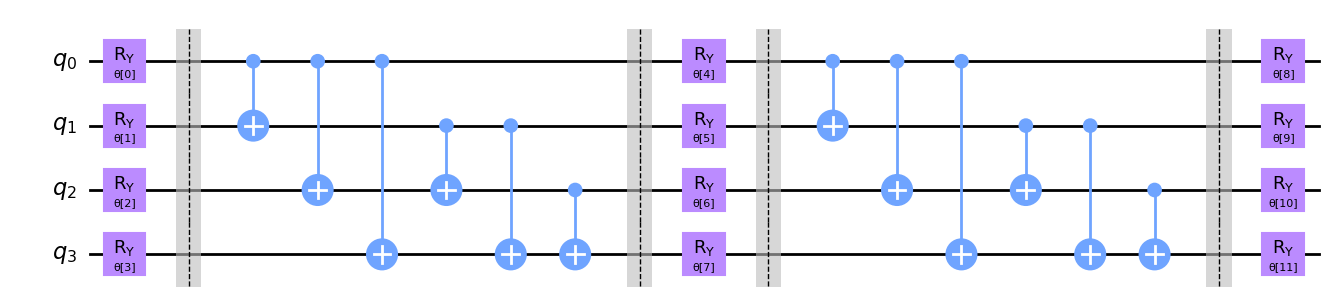

In [8]:
from qiskit.circuit.library import TwoLocal

#(num_qubits=None, rotation_blocks=None, entanglement_blocks=None, entanglement='full', reps=3, 
#   skip_final_rotation_layer=False, parameter_prefix='θ', insert_barriers=False, initial_state=None, name='TwoLocal')



TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks='cx', entanglement='full', reps=2, insert_barriers=True).decompose().draw(output="mpl")

**skip_final_rotation_layer** - If true removes a last varational layer that has no entanglement - works as a change of basis 

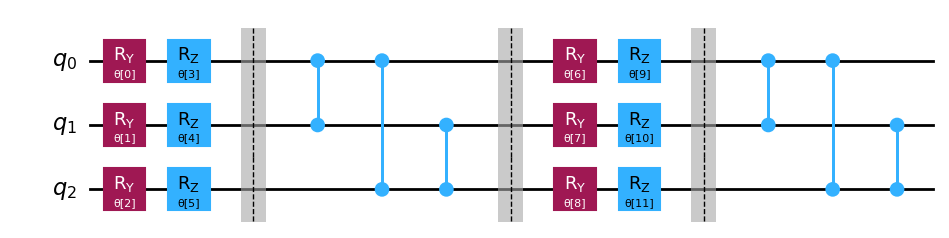

In [30]:
TwoLocal(3, ['ry','rz'], entanglement_blocks='cz', entanglement='full', reps=2, insert_barriers=True,skip_final_rotation_layer=True).decompose().draw(output="mpl")


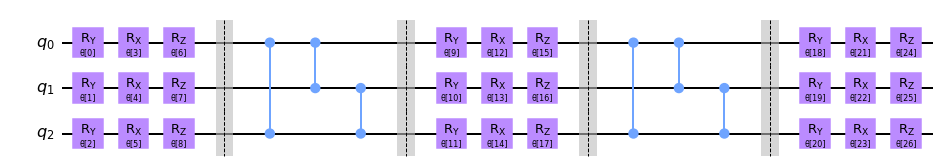

In [8]:
TwoLocal(3, ['ry','rx','rz'], 'cz', 'circular', reps=2, insert_barriers=True).decompose().draw(output="mpl")


#### **RealAmplitudes** 

The RealAmplitudes circuit is a heuristic trial wave function used as Ansatz in chemistry applications or classification circuits in machine learning. The circuit consists of of alternating layers of 𝑌 rotations and 𝐶𝑋 entanglements. The entanglement pattern can be user-defined or selected from a predefined set

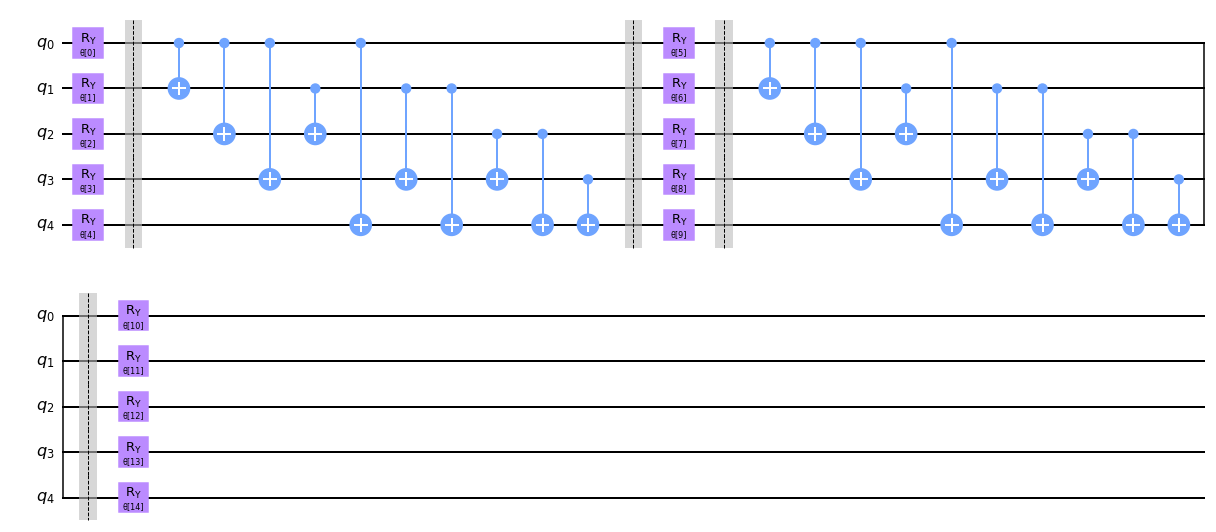

In [61]:
from qiskit.circuit.library import RealAmplitudes

#(num_qubits=None, entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, 
#   parameter_prefix='θ', insert_barriers=False, initial_state=None, name='RealAmplitudes')

RealAmplitudes(num_qubits=5, entanglement='full', reps=2, insert_barriers=True).decompose().draw(output='mpl')


#### **EfficientSU2** 

Hardware-efficient ansatz - The EfficientSU2 circuit consists of layers of single qubit operations spanned by SU(2) and 𝐶𝑋 entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or classification circuit for machine learning.

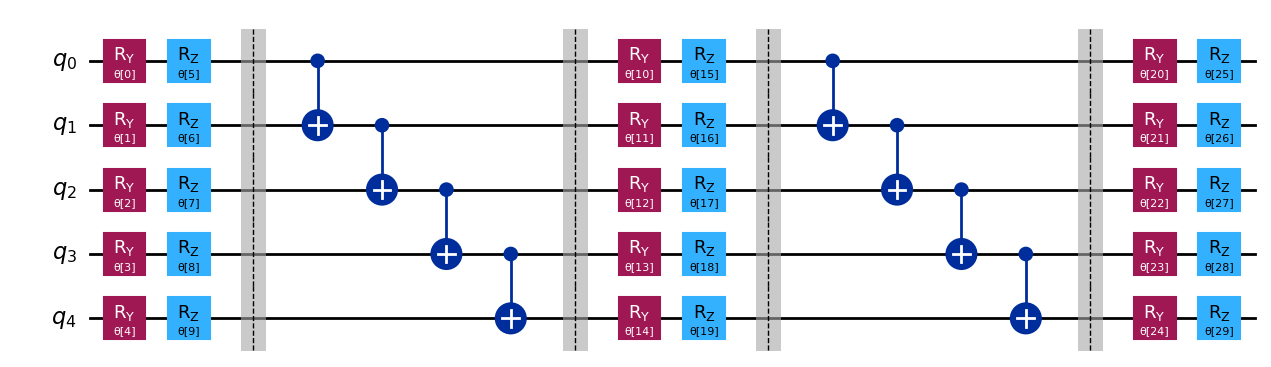

In [35]:
from qiskit.circuit.library import EfficientSU2

# (num_qubits=None, su2_gates=None, entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, parameter_prefix='θ',
#    insert_barriers=False, initial_state=None, name='EfficientSU2')
EfficientSU2(5, entanglement='linear', reps=2, insert_barriers=True).decompose().draw(output="mpl")


### Remember that since we are dealing with machine learning, we also need to encode classical data into the quantum system (Lecture 3 - Data encoding)

#### **PauliFeatureMap**
Pauli rotations for encoding the data

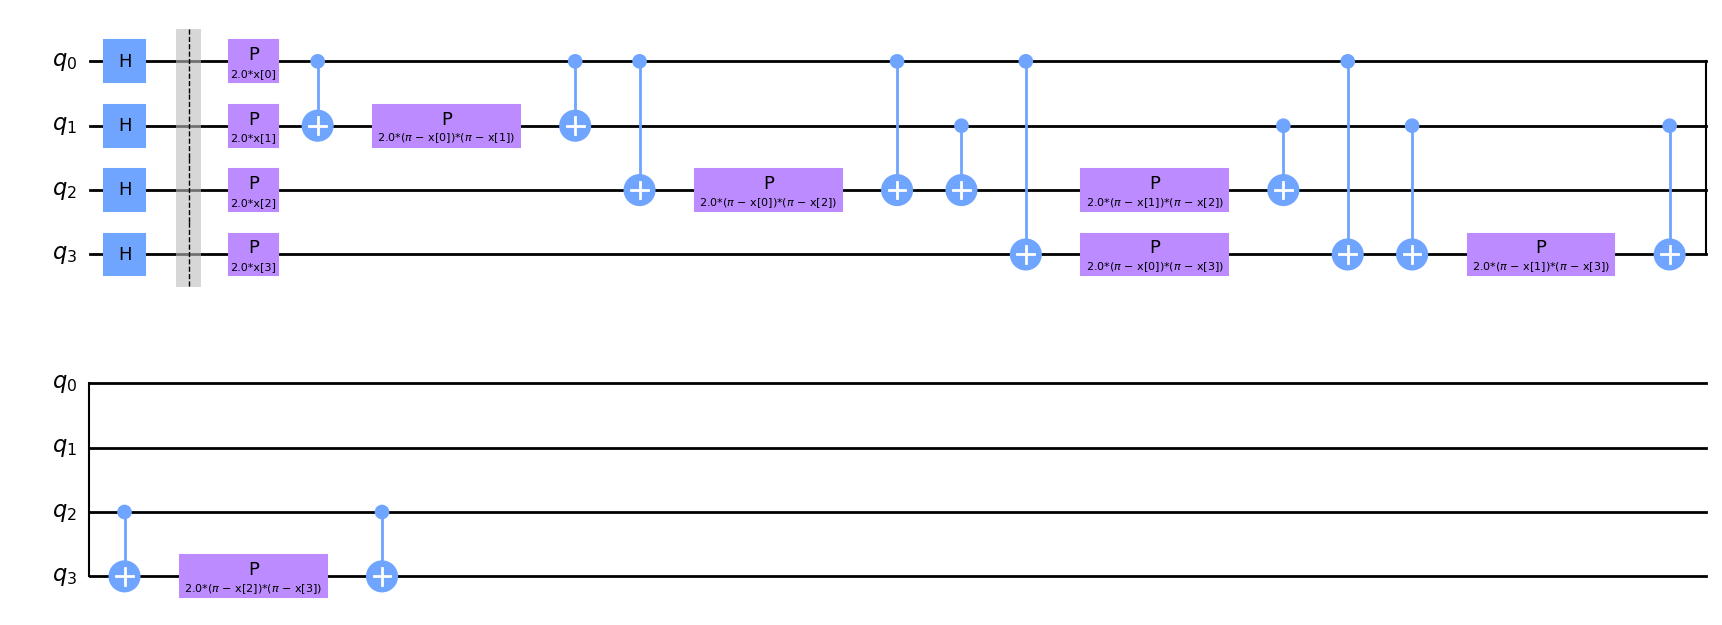

In [14]:
from qiskit.circuit.library import PauliFeatureMap

prep = PauliFeatureMap(4, reps=1, paulis=['Z','ZZ'], entanglement='full', insert_barriers=True)
prep.decompose().draw(output="mpl")

#### **ZZFeatureMap**

IQP encoding (Lecture 3 data encoding) - Classically hard to simulate 

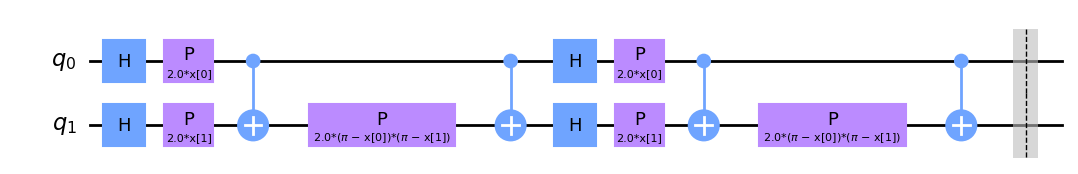

In [30]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

encoding = ZZFeatureMap(feature_dimension=2, reps=2)
encoding.barrier()

encoding.decompose().draw(output="mpl")

### Compose encoding and ansatz

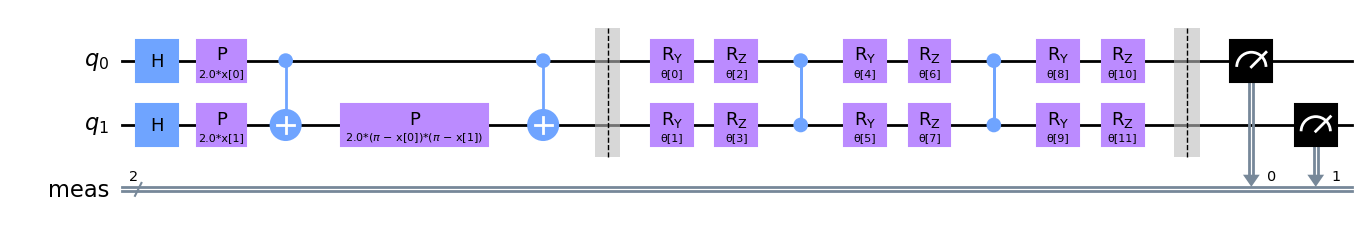

In [31]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

encoding = ZZFeatureMap(feature_dimension=2, reps=1)
encoding.barrier()

ansatz = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

qc = encoding.compose(ansatz)

qc.measure_all()

qc.decompose().draw(output="mpl")

## 2. VQC building blocks - Measurement <a id="measurement"></a>

Types of measurement ? What is a valid output of the quantum circuit ?

It depends on the type of problem we have: 

    1) Binary classification 
    2) Multi class classification
    3) Multi label classification

    
<p align="center">
    <img width="600" height="300" src="images/classification_types_copy.jpeg">
</p>

#### 1) Binary classification <a id="binary"></a>

    1.1) Single-qubit expectation value estimation
    
<p align="center">
    <img width="600" height="150" src="images/single_qubit.jpeg">
</p>

    1.2) Multiple-qubit expectation value estimation

<p align="center">
    <img width="600" height="150" src="images/multi_qubit.jpeg">
</p>

    1.3) Parity function

For binary classification, the parity function is widely used. We measure all qubits and build the histogram. Then we build a new probability distribution over $\{0,1\}$ (binary classification) by measuring the #1's of each of the measured basis states. If #1's is even we add to label 0 the probability of that basis state, otherwise we add to label 1.

<p align="center">
    <img width="800" height="400" src="images/parity.jpeg">
</p>

##### But now we have to work with probabilities instead of an expectation value. Can't use the MSE loss function no more. <a id="cross-entropy"></a>

Yet another loss function - The **cross-entropy** loss or **log-loss**

Let's consider labels in **one-hot encoding** because it will be helpful in the multi class setting:

$$ y=0 \mapsto [1,0] $$
$$ y=1 \mapsto [0,1] $$

Our model now give predictions as a probability distribution over classes e.g. $\hat{y} = [p_0 , p_1]$

*"Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0".*

$$ L(y,\hat{y}) = -\sum_{i=0}^{C-1} y_i log \hat{y}_i$$

The loss will be zero when the actual predicted probability is 1.

#### Code for the cross-entropy loss and respective cost function that uses the parity function devised in the previous exercise

#### Keep in mind that there is a tradeoff between using a single qubit expectation value or measurement and multi-qubit expectation value or measurement. Namely, the **expressivity-trainability tradeoff**:
 
 <p align="center">
    <img width="650" height="500" src="images/barren_plateau.jpeg">
</p>

In randomly generated ansatze, if we have a global cost function, in general the gradient magnitude will decay exponentially with the depth of the circuit and the the number of qubits. We want highly expressive circuits, however, we can run into problems when training these circuits. 

    1.4) Probability of each basis state from the quantum circuit itself
 The probability of each basis state corresponds to the probability of each class
 
 <p align="center">
    <img width="600" height="150" src="images/probs.jpeg">
</p>

How to perform parameter-shift rules  ? 

Let $P_0$ be the zero state projector 

$$P_0 = | 0 \rangle \langle 0 | = \begin{pmatrix}
                                            1 0\\
                                            0 0 
                                    \end{pmatrix}$$

and $P_1$ the one state projector

$$P_1 = | 1 \rangle \langle 1 | = \begin{pmatrix}
                                            0 0\\
                                            0 1 
                                    \end{pmatrix}$$

Parameter-shift rules become: 

$$\partial_{\theta} |\langle 0 | \psi(s,\theta) \rangle|^2 = \frac{1}{2} \biggl[ \langle  \psi(s,\theta)| P_0 | \psi(s,\theta)\rangle_{\theta + \frac{\pi}{2}}  - \langle  \psi(s,\theta)| P_0 | \psi(s,\theta)\rangle_{\theta - \frac{\pi}{2}}\biggr]$$




#### 2) Multi-class classification <a id="mutli-class"></a>

In this problem we have $C$ classes. We usually work with one-hot encoding. Thus, in this setting it will correspond to a vector of $C$ entries. Remember that for the labels in supervised learning, this will correspond to a vector of zeros with a single one at the entry of class $i$. E.g. 
    $$ y = [0,1,0,0] $$

indicates class 2 out of 4 possible classes.
    
    2.1) Probability of each basis state from the quantum circuit itself

Again, instead of using the softmax activation function in a set of $C$ observables, we can use a single observable and directly estimate the probability of each basis state corresponding to each class.

OR we could do a partition, for instance associate the probability of $c$ basis states to a given label

    2.2) Softmax activation function

Consider that we have a set of $C$ observables, one for representing each class. $O=\{O_0, \dots O_{C-1}\}$.

Suppose that the expectation value of each observable represent the output of the variational model for each class. 

$$ \langle O_c \rangle = \langle \psi(x,\theta)| O_{c} | \psi(x,\theta) \rangle$$

As in classical neural networks, we can use the softmax activation function to translate the continuous output of each expectation value in a probability distribution over classes as:

$$ P_c = \frac{e^{\langle O_c \rangle}}{\sum_{i=0}^{C-1} e^{\langle O_i \rangle} }$$

for class $c$. s.t $\sum_{c=0}^{C-1} P_c = 1$. The predictions of our model now are given by the vector:

$$ \hat{y} = [P_0, \dots , P_{C-1}] $$

These type of models are trained using the cross-entropy loss function introduced above.

$$ L(y,\hat{y}) = -\sum_{i=0}^{C-1} y_i log \hat{y}_i$$

## 3. VQC for the ad_hoc dataset <a id="ad_hoc"></a>

Qiskit no longer has several datasets that you can use in your own projects. <href>[qiskit_machine_learning.datasets](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.datasets.html)</href>

Scikit-learn has toy datasets as well - <href>[Scikit-learn datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)</href>

In [2]:
from qiskit_machine_learning.datasets import ad_hoc_data

Let's work with the ad_hoc dataset. Each datapoint has only two features, which make it relatively simple to encode into a quantum circuit. 

In [3]:
train_data, train_labels, test_data, test_labels= (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False))

Visualize the data in 2D 

Text(0.5, 1.0, 'ad_hoc dataset')

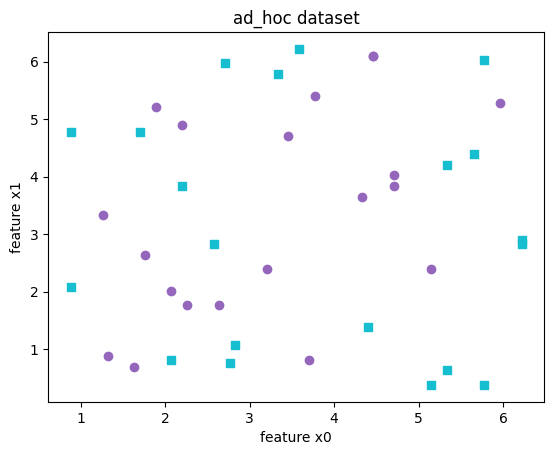

In [12]:
for feature, label in zip(train_data, train_labels):    
    if label:
        color = 'C4'
        marker = 'o'
        plt.scatter(feature[0], feature[1], color=color, marker=marker)
    else:
        color = 'C9'
        marker = 's'
        plt.scatter(feature[0], feature[1], color=color, marker=marker)

plt.xlabel("feature x0")
plt.ylabel("feature x1")
plt.title("ad_hoc dataset")

Let's first one-hot encode our labels. We can use the  <href>[sklearn library](https://scikit-learn.org/stable/) and use the OneHotEncoder. 

In [22]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

Let's define the variational quantum model:

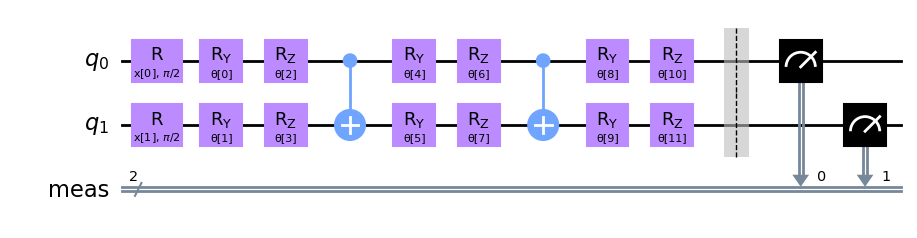

In [23]:
#encoding = ZZFeatureMap(feature_dimension=2, reps=1)
encoding = QuantumCircuit(2)

params = ParameterVector('x', length=2)
encoding.ry(params[0], 0)
encoding.ry(params[1], 1)


ansatz = TwoLocal(2, ['ry', 'rz'], 'cx', reps=2)

qc = encoding.compose(ansatz)
qc.measure_all()
qc.decompose().draw(output="mpl")

In [24]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA

def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

parameters = []
costs = []
evaluations = []
initial_point = np.random.random(ansatz.num_parameters)

vqc = VQC(feature_map=encoding,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=SPSA(maxiter=500, callback=store_intermediate_result),
          initial_point=initial_point)

vqc.fit(train_data, train_labels_oh)

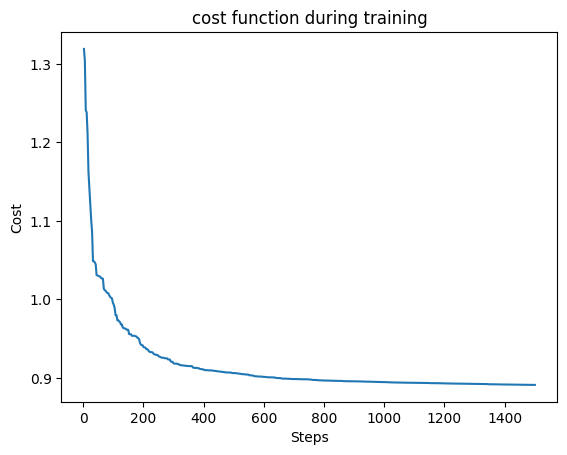

In [25]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

In [28]:
print("Test Score:",vqc.score(test_data, test_labels_oh))
print("Train Score:", vqc.score(train_data, train_labels_oh))

Test Score: 0.7
Train Score: 0.525


### Try to improve the accuracy of the model

In [32]:
## Your code here


from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA

def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

encoding = QuantumCircuit(2)

encoding = ZZFeatureMap(feature_dimension=2, reps=1)

ansatz = TwoLocal(2, ['ry', 'rz'], 'cx', reps=3)


parameters = []
costs = []
evaluations = []
initial_point = np.random.random(ansatz.num_parameters)

vqc = VQC(feature_map=encoding,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=SPSA(maxiter=500, callback=store_intermediate_result),
          initial_point=initial_point)

vqc.fit(train_data, train_labels_oh)


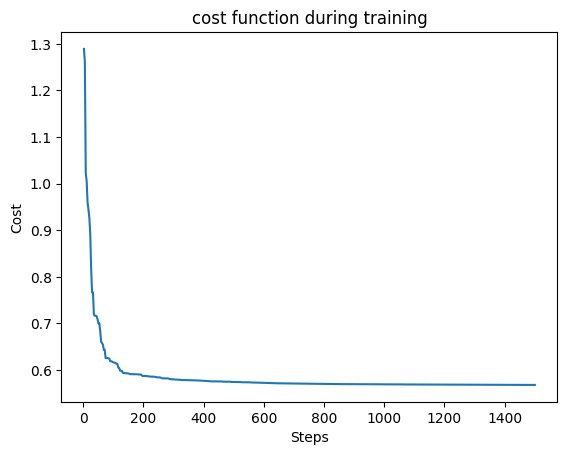

In [33]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

In [34]:
print("Test Score:",vqc.score(test_data, test_labels_oh))
print("Train Score:", vqc.score(train_data, train_labels_oh))

Test Score: 0.9
Train Score: 0.875


### Optimization 2

In [35]:
## Your code here


from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA

def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

encoding = PauliFeatureMap(2, reps=2, paulis=['Z','ZZ'], entanglement='full', insert_barriers=True)

ansatz = TwoLocal(2, ['ry', 'rz'], 'cx', reps=3)


parameters = []
costs = []
evaluations = []
initial_point = np.random.random(ansatz.num_parameters)

vqc = VQC(feature_map=encoding,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=SPSA(maxiter=500, callback=store_intermediate_result),
          initial_point=initial_point)

vqc.fit(train_data, train_labels_oh)


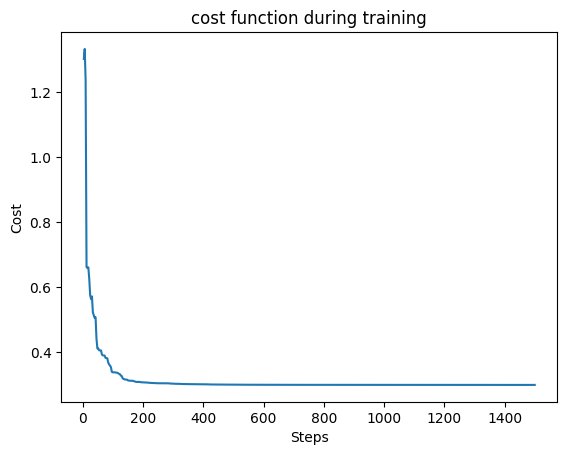

In [36]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

In [37]:
print("Test Score:",vqc.score(test_data, test_labels_oh))
print("Train Score:", vqc.score(train_data, train_labels_oh))

Test Score: 1.0
Train Score: 1.0


### Qiskit provides other modules with more flexibility

In [116]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

In [109]:
from qiskit.quantum_info import SparsePauliOp
 
 #two qubit ZZ observable. Any Pauli String can be used as an observable. Coeffs are the multiplicative coefficient of the Pauli string
observable = SparsePauliOp(["ZZ"], coeffs=[1])

qc = QNNCircuit(num_qubits=2,feature_map=encoding,
                ansatz=ansatz)

qnn = EstimatorQNN(circuit=qc,observables=observable)

In [110]:
model = NeuralNetworkClassifier(qnn, optimizer=SPSA(maxiter=500), loss='squared_error')

In [111]:
model.fit(train_data, train_labels)

In [114]:
model.score(test_data, test_labels)

0.4